In [1]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

from pybatteryid import ModelStructure
from pybatteryid.utilities import load_model_from_file
from pybatteryid.plotter import plot_time_vs_current, plot_time_vs_voltage

from data import helper

### Example 2 - Model Validation for an NMC Battery

This file contains an example to validate the identified battery models for a 1 Ah NMC battery. See [1] for more details.

#### References

[1] Sheikh, A. M. A., M. C. F. Donkers, and Henk Jan Bergveld. "A comprehensive approach to sparse identification of linear parameter-varying models for lithium-ion batteries using improved experimental design." Journal of Energy Storage 95 (2024): 112581. https://doi.org/10.1016/j.est.2024.112581

#### A. Initialize model structure

In [ ]:
# The NMC battery being modelled has the capacity around
# 1 Ah. The exact value has been calculated by coulomb-counting
# during GITT experiment. Note that the capacity is in Coulombs.
battery_capacity = 3440.05372
# The experimental measurements were recorded with 1s
# sampling period.
sampling_period = 1

model_structure = ModelStructure(battery_capacity=battery_capacity, sampling_period=sampling_period)

#### B. Load EMF data

In [3]:
#
emf_data = helper.load_npy_datasets('data/nmc/gitt_data.npy')
model_structure.add_emf_function({'soc_values': emf_data['soc_values'],
                                  'voltage_values': emf_data['voltage_values']})

#### C. Load battery model

We load the identified battery model from a file.

In [4]:
model = load_model_from_file('results/nmc/model_n,l=3,4.npy')

#### D. Add Basis Functions

In [5]:
model_structure.add_basis_functions(model.basis_function_strings)

#### E. Simulate output voltage

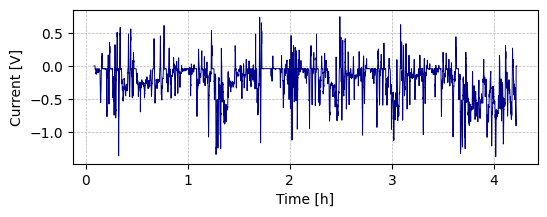

In [6]:
#
dataset = helper.load_npy_datasets(f'data/nmc/validation_data.npy')
#
plot_time_vs_current([(dataset['time'] / 3600, dataset['current'])],
                     units=('h', 'V'), colors=['darkblue'])

In [7]:
# To perform fair comparison, we provide same number of initial
# voltage values to each model. For example, the model with n=4
# requires four initial voltage values. If n=4 is the largest model
# order to be investigated, then we provide four initial values to all
# models, that is, n=1,2,3,4. Note that such consideration may not have
# significant impact on the actual comparison, but is legit in principle.
no_of_initial_values = 4
# 
current_profile = {'initial_soc': dataset['initial_soc'],
                   'time_values': dataset['time'],
                   'current_values': dataset['current'],
                   'voltage_values': dataset['voltage'][:no_of_initial_values]}
#
voltage_simulated = model_structure.simulate(model, current_profile)

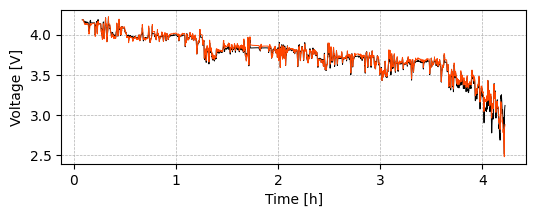

In [8]:
#
plot_time_vs_voltage([(dataset['time'] / 3600, dataset['voltage']), (dataset['time'] / 3600, voltage_simulated)],
                     units=('h', 'V'), colors=['k', 'orangered'])

#### F. Error Analysis

In [9]:
# We find error values for the whole region
rmse = root_mean_squared_error( voltage_simulated[no_of_initial_values:], dataset['voltage'][no_of_initial_values:] )
mae = mean_absolute_error( voltage_simulated[no_of_initial_values:], dataset['voltage'][no_of_initial_values:] )

print(f"The errors are given as: (RMSE, MAE) = ({rmse * 1e3} mV, {mae * 1e3} mV)")

The errors are given as: (RMSE, MAE) = (29.333880936401687 mV, 18.841924193159088 mV)
